#Data Preprocessing

In [1]:
import torch, numpy as np, random

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

In [2]:
#Extracting zip file

import zipfile
import os

zip = "/content/RAVDESS_speech_audio.zip"
extract_dir = "/content/RAVDESS_speech_audio"

os.makedirs(extract_dir, exist_ok = True)

with zipfile.ZipFile(zip, "r") as zip_ref:
  zip_ref.extractall(extract_dir)

print("Extraction complete. Files extracted to:", extract_dir)

Extraction complete. Files extracted to: /content/RAVDESS_speech_audio


In [3]:
#Verification of zip extraction

import glob

wav_files = glob.glob(extract_dir + "/**/*.wav", recursive = True)
print("Number of audio files:", len(wav_files))
print("Example file:", wav_files[0] if wav_files else "None found")

Number of audio files: 2880
Example file: /content/RAVDESS_speech_audio/Actor_07/03-01-07-01-02-01-07.wav


In [4]:
#Setup

import librosa
import numpy as np
from tqdm import tqdm

target_sample_rate = 16000

def load_and_resample(path, target_sr = target_sample_rate):
  y, sr = librosa.load(path, sr = target_sr, mono = True)
  return y, sr

In [5]:
#Normalization of the audio

def peak_normalize(y, peak = 0.99):
  max_amp = np.max(np.abs(y)) + 1e-9
  return (y / max_amp) * peak

In [6]:
#Silence Trimming

def safe_trim_silence(y, top_db = 30, min_keep_ratio = 0.5):
  y_trimmed, idx = librosa.effects.trim(y, top_db = top_db)
  keep_ratio = len(y_trimmed) / len(y)
  if keep_ratio < min_keep_ratio:
    return y, (0, len(y))
  return y_trimmed, idx

In [7]:
#Cleaning function

def clean_audio(path, target_sr = target_sample_rate):
  #Load and resample audio
  y, sr = librosa.load(path, sr = target_sr, mono = True)
  #Normalize loudness
  y = peak_normalize(y, peak = 0.99)
  #Trim silence while avoiding speech
  y, _ = safe_trim_silence(y, top_db = 30, min_keep_ratio = 0.5)
  return y, target_sr

In [8]:
import soundfile as sf

AUDIO_DIR = "/content/RAVDESS_speech_audio"
OUTPUT_DIR = "/content/ravdess_audio_cleaned"

os.makedirs(OUTPUT_DIR, exist_ok=True)

wav_files = glob.glob(AUDIO_DIR + "/**/*.wav", recursive=True)
print("Found", len(wav_files), "audio files.")


for path in tqdm(wav_files, desc="Cleaning audio"):
    y, sr = clean_audio(path)

    #Save cleaned version
    filename = os.path.basename(path)
    out_path = os.path.join(OUTPUT_DIR, filename)
    sf.write(out_path, y, sr)


Found 2880 audio files.


Cleaning audio: 100%|██████████| 2880/2880 [00:37<00:00, 77.70it/s] 


In [9]:
cleaned_files = glob.glob(OUTPUT_DIR + "/*.wav")
print("Cleaned files:", len(cleaned_files))

durations = []
for f in cleaned_files[:500]:
  y, sr = librosa.load(f, sr = None)
  durations.append(len(y) / sr)

print("Minimum Durations:", np.min(durations))
print("Maximum Durations:", np.max(durations))
print("Average Durations:", np.mean(durations))

Cleaned files: 1440
Minimum Durations: 1.76
Maximum Durations: 4.604625
Average Durations: 2.9886899999999996


#Wave2Vec Model

In [10]:
#Wave2Vec Setup

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

from transformers import Wav2Vec2Processor, Wav2Vec2Model

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

Using device: cuda


In [12]:
CLEAN_DIR = "/content/ravdess_audio_cleaned"

cleaned_files = glob.glob(os.path.join(CLEAN_DIR, "*.wav"))
print("Number of Cleaned files:", len(cleaned_files))
cleaned_files[:5]

Number of Cleaned files: 1440


['/content/ravdess_audio_cleaned/03-01-05-01-02-01-23.wav',
 '/content/ravdess_audio_cleaned/03-01-08-01-02-01-05.wav',
 '/content/ravdess_audio_cleaned/03-01-04-01-01-01-05.wav',
 '/content/ravdess_audio_cleaned/03-01-06-01-02-01-11.wav',
 '/content/ravdess_audio_cleaned/03-01-08-01-01-02-06.wav']

In [13]:
#Emotion Mapping

EMOTION_MAP = {
    1: "neutral",
    2: "calm",
    3: "happy",
    4: "sad",
    5: "angry",
    6: "fearful",
    7: "disgust",
    8: "surprised"
}

def parse_emotion_and_actor(path):
  fname = os.path.basename(path)
  stem = os.path.splitext(fname)[0]
  parts = stem.split("-")
  em_code = int(parts[2])
  actor_id = int(parts[-1])
  label_id = em_code - 1
  return label_id, actor_id

In [14]:
#Sanity check

for f in cleaned_files[:5]:
  label_id, actor_id = parse_emotion_and_actor(f)
  print(os.path.basename(f), "->", EMOTION_MAP[label_id + 1], "label", label_id, ")", "actor", actor_id)

03-01-05-01-02-01-23.wav -> angry label 4 ) actor 23
03-01-08-01-02-01-05.wav -> surprised label 7 ) actor 5
03-01-04-01-01-01-05.wav -> sad label 3 ) actor 5
03-01-06-01-02-01-11.wav -> fearful label 5 ) actor 11
03-01-08-01-01-02-06.wav -> surprised label 7 ) actor 6


In [15]:
#Train/Val/Test

train_file, val_files, test_files = [], [], []

for f in cleaned_files:
  label_id, actor_id = parse_emotion_and_actor(f)

  if 1<= actor_id <= 16:
    train_file.append(f)
  elif 17 <= actor_id <= 20:
    val_files.append(f)
  else:
    test_files.append(f)

print("Training Files:", len(train_file))
print("Validation Files:", len(val_files))
print("Testing Files:", len(test_files))

Training Files: 960
Validation Files: 240
Testing Files: 240


In [16]:
#Calling wav2vec

from transformers import Wav2Vec2Processor

processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/configuration_utils.py:335: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

In [17]:
class RAVDESSWav2VecDataset(Dataset):
    def __init__(self, file_paths, target_sr = target_sample_rate):
        self.file_paths = file_paths
        self.target_sr = target_sr

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        path = self.file_paths[idx]
        label_id, actor_id = parse_emotion_and_actor(path)

        #Load cleaned audio
        y, sr = librosa.load(path, sr = None, mono = True)
        if sr != self.target_sr:
            y = librosa.resample(y, orig_sr = sr, target_sr = self.target_sr)
            sr = self.target_sr

        return {
            "input_values": y.astype(np.float32),
            "labels": label_id
        }

In [18]:
#Collate function

def collate_fn(batch):
    input_values = [b["input_values"] for b in batch]
    labels = torch.tensor([b["labels"] for b in batch], dtype = torch.long)

    batch_inputs = processor(
        input_values,
        sampling_rate = target_sample_rate,
        return_tensors="pt",
        padding=True
    )

    input_tensor = batch_inputs["input_values"]

    return {
        "input_values": input_tensor,
        "labels": labels
    }

In [19]:
#Data loaders

BATCH_SIZE = 8

train_dataset = RAVDESSWav2VecDataset(train_file)
val_dataset   = RAVDESSWav2VecDataset(val_files)
test_dataset  = RAVDESSWav2VecDataset(test_files)

train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True, collate_fn = collate_fn)
val_loader   = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = False, collate_fn = collate_fn)
test_loader  = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = False, collate_fn = collate_fn)

In [20]:
#Wav2Vec Model

class Wav2Vec2Classifier(nn.Module):
    def __init__(self, model_name="facebook/wav2vec2-base", num_labels = 8):
        super().__init__()
        self.wav2vec2 = Wav2Vec2Model.from_pretrained(model_name)
        hidden_size = self.wav2vec2.config.hidden_size

        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_size, num_labels)
        )

    def forward(self, input_values, labels=None):
        outputs = self.wav2vec2(input_values=input_values)
        last_hidden_state = outputs.last_hidden_state

        #Simple Mean Pooling
        pooled = last_hidden_state.mean(dim = 1)

        logits = self.classifier(pooled)

        loss = None
        if labels is not None:
            loss_fn = nn.CrossEntropyLoss()
            loss = loss_fn(logits, labels)

        return logits, loss

In [21]:
#Initializing Model and optimizer

model = Wav2Vec2Classifier(num_labels = 8).to(DEVICE)

#freeze wav2vec encoder so that only the classifier head is trained
for param in model.wav2vec2.parameters():
    param.requires_grad = False

for layer in model.wav2vec2.encoder.layers[-2:]:
    for param in layer.parameters():
        param.requires_grad = True

encoder_params = [p for p in model.wav2vec2.parameters() if p.requires_grad]
classifier_params = list(model.classifier.parameters())

optimizer = torch.optim.AdamW(
    [
        {"params": classifier_params, "lr": 1e-3},  #Faster LR for classifier
        {"params": encoder_params,   "lr": 1e-5},   #Small LR for fine tuning layers
    ]
)
EPOCHS = 30

pytorch_model.bin:   0%|          | 0.00/380M [00:00<?, ?B/s]

In [22]:
#Training and Val loop

def train_one_epoch(model, dataloader, optimizer, device = DEVICE):
    model.train()
    total_loss = 0.0

    for batch in dataloader:
        input_values = batch["input_values"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()
        logits, loss = model(input_values = input_values, labels = labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * input_values.size(0)

    return total_loss / len(dataloader.dataset)


def evaluate(model, dataloader, device=DEVICE):
    model.eval()
    total_loss = 0.0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in dataloader:
            input_values = batch["input_values"].to(device)
            labels = batch["labels"].to(device)

            logits, loss = model(input_values = input_values, labels = labels)
            total_loss += loss.item() * input_values.size(0)

            preds = torch.argmax(logits, dim = -1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(dataloader.dataset)
    acc = accuracy_score(all_labels, all_preds)
    macro_f1 = f1_score(all_labels, all_preds, average="macro")
    return avg_loss, acc, macro_f1, np.array(all_labels), np.array(all_preds)

In [23]:
#Training Run

train_losses = []
val_losses = []
val_accuracies = []
val_macro_f1s = []

for epoch in range(1, EPOCHS + 1):
    train_loss = train_one_epoch(model, train_loader, optimizer)
    val_loss, val_acc, val_f1, _, _ = evaluate(model, val_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    val_macro_f1s.append(val_f1)

    print(f"Epoch {epoch}/{EPOCHS}")
    print(f" Training Loss: {train_loss:.4f}")
    print(f" Validation Loss:   {val_loss:.4f}")
    print(f" Validation Acc:    {val_acc:.4f}")
    print(f" Validation Macro-F1: {val_f1:.4f}")

model.safetensors:   0%|          | 0.00/380M [00:00<?, ?B/s]

Epoch 1/30
 Training Loss: 1.8478
 Validation Loss:   1.8605
 Validation Acc:    0.2792
 Validation Macro-F1: 0.2288
Epoch 2/30
 Training Loss: 1.4483
 Validation Loss:   1.5548
 Validation Acc:    0.4000
 Validation Macro-F1: 0.3684
Epoch 3/30
 Training Loss: 1.1903
 Validation Loss:   1.5805
 Validation Acc:    0.4042
 Validation Macro-F1: 0.3947
Epoch 4/30
 Training Loss: 0.9831
 Validation Loss:   1.5806
 Validation Acc:    0.4417
 Validation Macro-F1: 0.4360
Epoch 5/30
 Training Loss: 0.8078
 Validation Loss:   1.5598
 Validation Acc:    0.4917
 Validation Macro-F1: 0.4844
Epoch 6/30
 Training Loss: 0.6926
 Validation Loss:   1.6085
 Validation Acc:    0.5208
 Validation Macro-F1: 0.5244
Epoch 7/30
 Training Loss: 0.5735
 Validation Loss:   1.7460
 Validation Acc:    0.5083
 Validation Macro-F1: 0.5034
Epoch 8/30
 Training Loss: 0.4922
 Validation Loss:   1.9384
 Validation Acc:    0.5000
 Validation Macro-F1: 0.4774
Epoch 9/30
 Training Loss: 0.4388
 Validation Loss:   1.9839
 Va

In [24]:
#Confusion Matrix

test_loss, test_acc, test_macro_f1, y_true, y_pred = evaluate(model, test_loader)

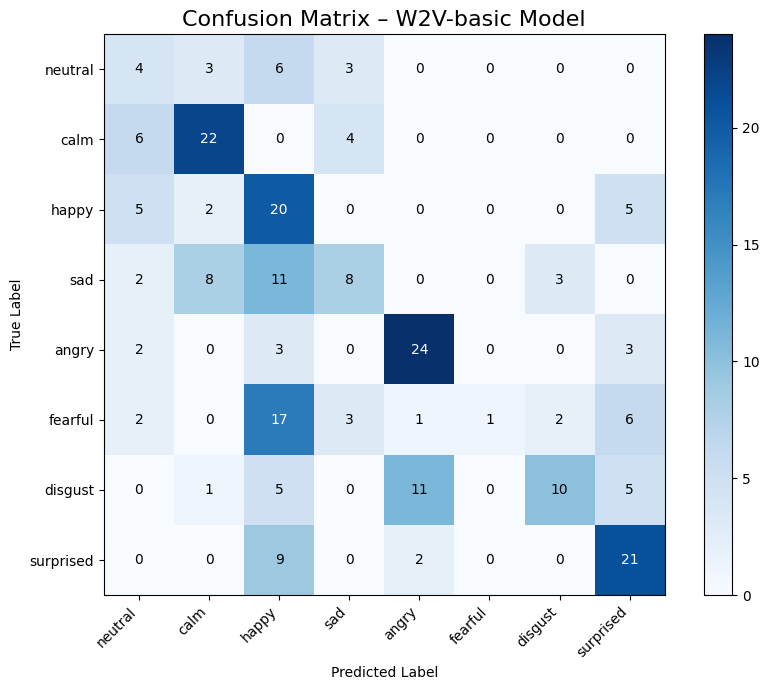

In [25]:
#Confusion Matrix

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

cm = confusion_matrix(y_true, y_pred)
classes = [EMOTION_MAP[i+1] for i in range(8)]

plt.figure(figsize = (9,7))
plt.imshow(cm, interpolation = "nearest", cmap = "Blues")
plt.title("Confusion Matrix – W2V-basic Model", fontsize = 16)
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation = 45, ha = "right")
plt.yticks(tick_marks, classes)

# Annotate cell values
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(
            j, i, format(cm[i, j], "d"),
            ha = "center", va = "center",
            color = "white" if cm[i, j] > thresh else "black",
            fontsize = 10
        )

plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()

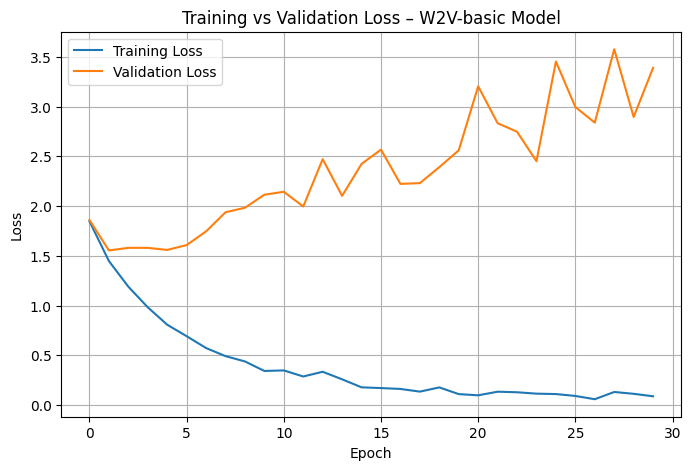

In [26]:
#Loss Curves

plt.figure(figsize=(8,5))
plt.plot(train_losses, label = "Training Loss")
plt.plot(val_losses, label = "Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss – W2V-basic Model")
plt.legend()
plt.grid(True)
plt.show()

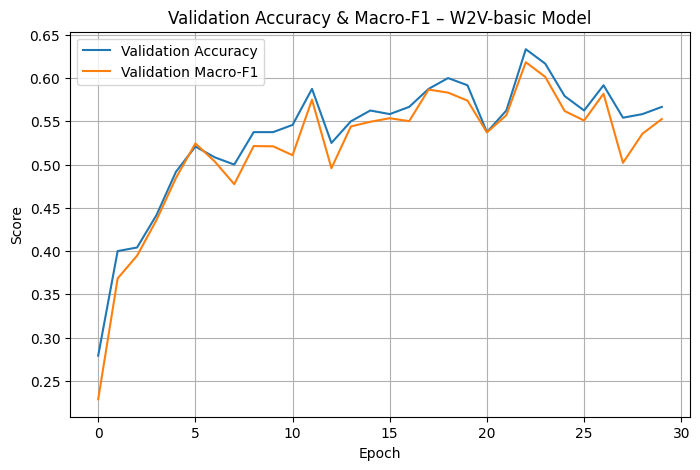

In [31]:
#Validation Accuracy and Macro-F1

plt.figure(figsize=(8,5))
plt.plot(val_accuracies, label = "Validation Accuracy")
plt.plot(val_macro_f1s, label = "Validation Macro-F1")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Validation Accuracy & Macro-F1 – W2V-basic Model")
plt.legend()
plt.grid(True)
plt.show()